# Intraday Impact of Elon Musk's Tweets on Tesla Stock

## Introduction

This notebook analyses the immediate impact of Elon Musk's tweets on Tesla's stock prices using minute-by-minute data. The analysis includes:

1. **Data Loading**: Load tweets and Tesla's stock price data.
2. **Market Status**: Identify whether the market was open at the time of each tweet.
3. **Price & Return Calculation**: Compute the stock price at the time of the tweet and 10 minutes after, and calculate the stock return within 10 minutes after each tweet.
4. **Tweet Distribution**: Analyse the distribution of tweets by the hour of the day.
5. **Price Movement Analysis**: Extract price data for 10 minutes before and after each tweet, classify tweets based on price changes, and compare the average price movements.

Through this analysis, we aim to understand how Elon Musk's tweets impact Tesla's stock price in the short term...

## 1. Data Loading

In [1]:
# Imports necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File paths
tweets_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Tweets_Elon_Musk_Intraday_Analysis.csv'
stock_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Tesla_minute_historical_data.csv'

In [3]:
# Load datasets
tweets_market_open = pd.read_csv(tweets_file_path)
price_tsla = pd.read_csv(stock_file_path)

In [4]:
# Convert datetime columns to datetime objects
tweets_market_open['datetime'] = pd.to_datetime(tweets_market_open['datetime'], format='%d/%m/%Y %H:%M')
price_tsla['Date'] = pd.to_datetime(price_tsla['Date'], format='%d/%m/%Y %H:%M')

# Set the datetime as the index for price_tsla
price_tsla.set_index('Date', inplace=True)

In [5]:
tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views
0,2024-05-02 16:25:00,Proposed law: if someone tears down the Americ...,0,40000,53000,152000,40000000
1,2024-05-02 17:41:00,"I’m not saying they can’t come back, but they ...",0,4700,3900,49000,2300000
2,2024-05-02 18:18:00,The Democratic National Convention this August...,0,1000,2000,11000,1700000
3,2024-05-02 18:21:00,"Posting long form text, audio & video content ...",1,4300,8700,44000,18000000
4,2024-05-03 04:34:00,This is wild!,1,3200,21000,64000,14000000


In [6]:
price_tsla.head()

,Open,High,Low,Close,Tick Count,Volume
Date,,,,,,
2024-05-01 14:30:00,182.0000,184.1100,181.732,183.3952,2555,1305549
2024-05-01 14:31:00,183.4200,183.5509,182.110,182.1799,1420,380497
2024-05-01 14:32:00,182.1300,182.8400,181.880,182.6700,1490,346146
2024-05-01 14:33:00,182.6700,183.1600,181.560,181.5800,1290,327344
2024-05-01 14:34:00,181.5777,181.5777,180.520,180.6300,1912,511523


## 2. Market Status

In [7]:
# Determine if the market was open at the time of the tweet
tweets_market_open['market_open'] = tweets_market_open['datetime'].isin(price_tsla.index)

tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views,market_open
0,2024-05-02 16:25:00,Proposed law: if someone tears down the Americ...,0,40000,53000,152000,40000000,True
1,2024-05-02 17:41:00,"I’m not saying they can’t come back, but they ...",0,4700,3900,49000,2300000,True
2,2024-05-02 18:18:00,The Democratic National Convention this August...,0,1000,2000,11000,1700000,True
3,2024-05-02 18:21:00,"Posting long form text, audio & video content ...",1,4300,8700,44000,18000000,True
4,2024-05-03 04:34:00,This is wild!,1,3200,21000,64000,14000000,False


## 3. Price & Return Calculation

In [8]:
# Add the closing price at the time of the tweet
tweets_market_open['price'] = tweets_market_open.apply(
    lambda row: price_tsla.loc[row['datetime'], 'Close'] if row['market_open'] else None, axis=1
)

In [9]:
# Add the closing price 10 minutes after the tweet
tweets_market_open['price_10min'] = tweets_market_open.apply(
    lambda row: price_tsla.loc[row['datetime'] + pd.Timedelta(minutes=10), 'Close'] 
    if row['market_open'] and (row['datetime'] + pd.Timedelta(minutes=10)) in price_tsla.index 
    else None, 
    axis=1
)

In [10]:
# Calculate the return
tweets_market_open['return'] = tweets_market_open.apply(
    lambda row: np.exp(np.log(row['price_10min'] / row['price'])) - 1 
    if pd.notnull(row['price']) and pd.notnull(row['price_10min']) and row['price'] != 0 else None, 
    axis=1
)

In [11]:
tweets_market_open[['price', 'price_10min', 'return', 'market_open']].head()

,price,price_10min,return,market_open
0,179.574,179.7600,0.001036,True
1,179.400,179.6850,0.001589,True
2,179.967,180.3650,0.002212,True
3,180.280,180.2654,-0.000081,True
4,NaN,NaN,NaN,False


## 4. Tweet Distribution

In [12]:
# Extract the hour from the datetime column
tweets_market_open['hour'] = tweets_market_open['datetime'].dt.hour

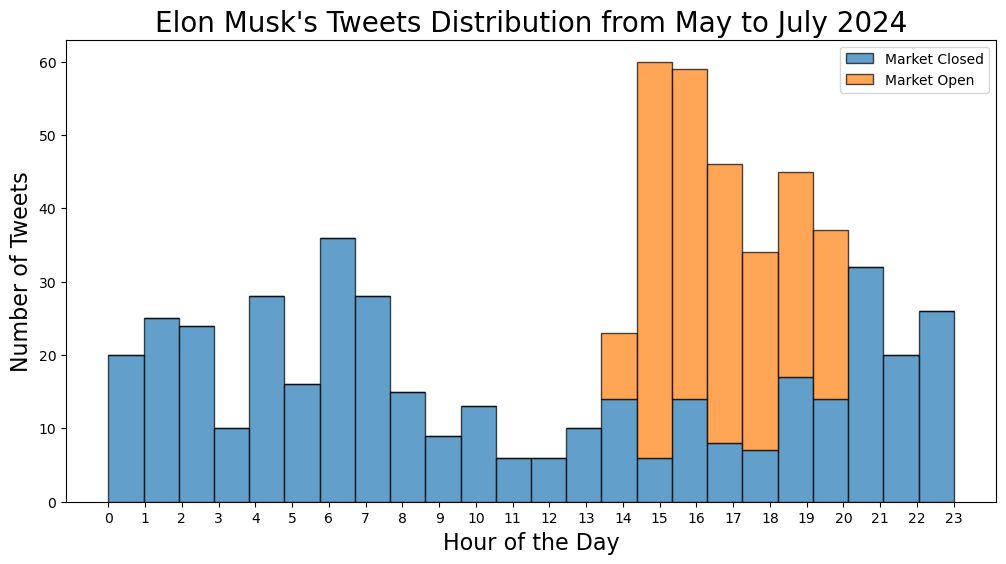

In [13]:
# Plot the distribution of tweets by hour
plt.figure(figsize=(12, 6))
plt.hist([tweets_market_open[tweets_market_open['market_open'] == False]['hour'], 
          tweets_market_open[tweets_market_open['market_open'] == True]['hour']],
         bins=24, stacked=True, edgecolor='black', label=['Market Closed', 'Market Open'], alpha=0.7)
plt.xticks(range(24))
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Number of Tweets', fontsize=16)
plt.title('Elon Musk\'s Tweets Distribution from May to July 2024', fontsize=20)
plt.legend()
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Tesla/figure_0.1.png', format='png', dpi=300)
plt.show()

## 5. Price Movement Analysis

In [14]:
# Filter for tweets during market open times
tweets_market_open = tweets_market_open[tweets_market_open['market_open']].copy()
tweets_market_open['id'] = range(1, len(tweets_market_open) + 1)

tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views,market_open,price,price_10min,return,hour,id
0,2024-05-02 16:25:00,Proposed law: if someone tears down the Americ...,0,40000,53000,152000,40000000,True,179.574,179.7600,0.001036,16,1
1,2024-05-02 17:41:00,"I’m not saying they can’t come back, but they ...",0,4700,3900,49000,2300000,True,179.400,179.6850,0.001589,17,2
2,2024-05-02 18:18:00,The Democratic National Convention this August...,0,1000,2000,11000,1700000,True,179.967,180.3650,0.002212,18,3
3,2024-05-02 18:21:00,"Posting long form text, audio & video content ...",1,4300,8700,44000,18000000,True,180.280,180.2654,-0.000081,18,4
22,2024-05-06 18:13:00,Although Boeing got $4.2 billion to develop an...,1,7700,20000,129000,49000000,True,183.801,184.4800,0.003694,18,5


In [15]:
# Function to extract and fill the price window around each tweet
def get_price_window_filled(datetime):
    start_time = datetime - pd.Timedelta(minutes=10)
    end_time = datetime + pd.Timedelta(minutes=10)
    time_range = pd.date_range(start=start_time, end=end_time, freq='min')
    price_window = []
    for t in time_range:
        if t in price_tsla.index:
            price_window.append(price_tsla.loc[t, 'Close'])
        else:
            price_window.append(np.nan)
    # Replace front NaNs with the first available price
    first_valid = next((x for x in price_window if not np.isnan(x)), None)
    if first_valid is not None:
        price_window = [first_valid if np.isnan(x) else x for x in price_window]
    
    # Replace back NaNs with the last available price
    last_valid = next((x for x in reversed(price_window) if not np.isnan(x)), None)
    if last_valid is not None:
        price_window = [last_valid if np.isnan(x) else x for x in reversed(price_window)]
        price_window = list(reversed(price_window))
    
    return price_window

In [16]:
# Extract and combine the price windows
price_windows = [get_price_window_filled(datetime) for datetime in tweets_market_open['datetime']]

In [17]:
# Create column names for the price windows
columns = [f"T{i}" for i in range(-10, 11)]

# Create a new dataframe with the price windows
price_window_df = pd.DataFrame(price_windows, columns=columns)
price_window_df['id'] = tweets_market_open['id'].values
price_window_df.set_index('id', inplace=True)

price_window_df.head()

,T-10,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,...,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
id,,,,,,,,,,,,,,,,,,,,,
1,179.4200,179.8655,179.6875,179.430,179.1200,178.8500,179.1100,179.274,179.300,179.8250,...,179.476,179.1193,179.4267,179.9530,179.9448,179.430,179.1471,179.5100,179.5199,179.7600
2,178.7200,178.8200,179.0097,179.015,178.8057,178.5599,178.9887,179.020,179.310,179.4418,...,179.320,179.5517,179.6150,179.5201,179.6194,179.550,179.2450,179.6289,179.5402,179.6850
3,180.1316,180.1799,180.0600,180.080,179.9000,180.1500,179.9050,180.032,180.030,180.0750,...,179.920,180.1000,180.2800,180.0400,180.0650,180.065,180.0500,180.0800,180.1100,180.3650
4,180.0800,179.9000,180.1500,179.905,180.0320,180.0300,180.0750,179.967,179.920,180.1000,...,180.040,180.0650,180.0650,180.0500,180.0800,180.110,180.3650,180.4101,180.3302,180.2654
5,184.0508,184.0500,184.1350,184.270,184.2000,183.7402,183.9600,183.970,183.895,183.8600,...,183.910,183.8213,183.8500,183.8400,184.1900,184.250,183.9550,184.2601,184.3799,184.4800


In [18]:
# Calculate mean price movements
mean_price = price_window_df.mean()

# Classify tweets into positive and negative based on T10 and T0
positive_tweets = price_window_df[price_window_df['T10'] > price_window_df['T0']]
negative_tweets = price_window_df[price_window_df['T10'] <= price_window_df['T0']]

# Calculate mean price movements for positive and negative tweets
mean_positive_price = positive_tweets.mean()
mean_negative_price = negative_tweets.mean()

# Normalize price movements to let T0 be 0 for comparison
mean_price_normalized = mean_price - mean_price['T0']
mean_positive_price_normalized = mean_positive_price - mean_positive_price['T0']
mean_negative_price_normalized = mean_negative_price - mean_negative_price['T0']

# Calculate the number of positive and negative tweets
num_positive_tweets = len(positive_tweets)
num_negative_tweets = len(negative_tweets)
num_all_tweets = len(price_window_df)

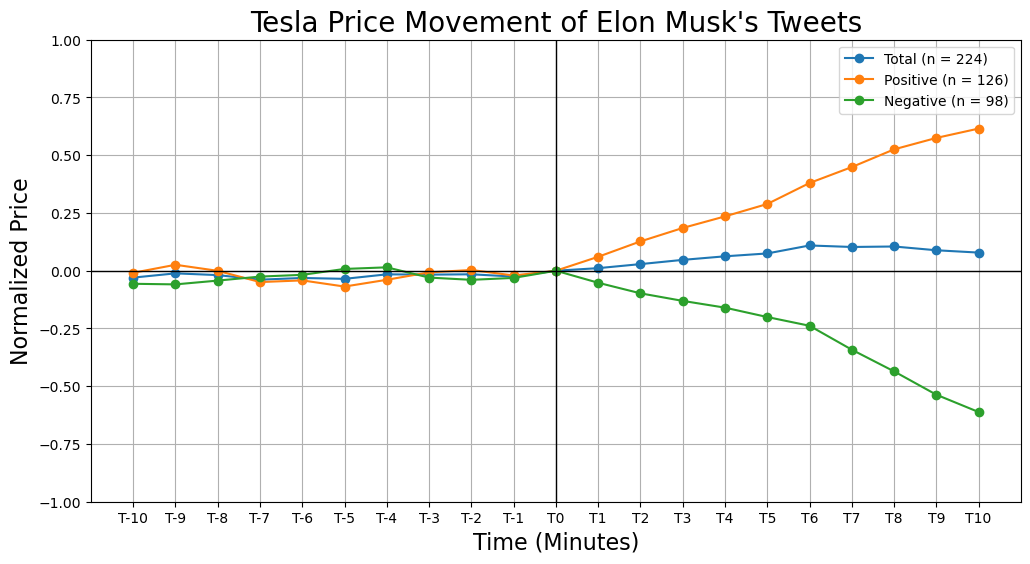

In [19]:
# Plot the normalized mean price movements with custom line colors and labels
plt.figure(figsize=(12, 6))
plt.plot(mean_price_normalized.index, mean_price_normalized.values, label=f'Total (n = {num_all_tweets})', marker='o', color='C0')
plt.plot(mean_positive_price_normalized.index, mean_positive_price_normalized.values, label=f'Positive (n = {num_positive_tweets})', marker='o', color='C1')
plt.plot(mean_negative_price_normalized.index, mean_negative_price_normalized.values, label=f'Negative (n = {num_negative_tweets})', marker='o', color='C2')

# Adding thicker grid lines at T0 and 0
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axvline('T0', color='black', linestyle='-', linewidth=1)

plt.ylim(-1.0, 1.0)
plt.xlabel('Time (Minutes)', fontsize=16)
plt.ylabel('Normalized Price', fontsize=16)
plt.title('Tesla Price Movement of Elon Musk\'s Tweets', fontsize=20)
plt.legend()
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Tesla/figure_0.2.png', format='png', dpi=300)
plt.show()

# Sentiment Analysis on Elon Musk's Tweets (Unsupervised)

## Introduction

This notebook performs a sentiment analysis on Elon Musk's tweets to evaluate their impact on public sentiment, particularly in relation to Tesla's stock performance. The analysis employs several methods to assess sentiment, including:

1. **Data Pre-processing**: Clean and prepare the tweet data for analysis by tokenizing, stemming, and removing noise.
2. **Dictionary Method of Apel and Grimaldi's**: Apply a dictionary-based approach to quantify sentiment using predefined positive and negative words.
3. **Rule-based Methods: VADER and TextBlob**: Utilize rule-based sentiment analysis tools, VADER and TextBlob, to gauge the sentiment of tweets.
4. **Sentiment Visualization**: Visualize the distribution of positive and negative sentiments across different methods.
5. **Performance Evaluation**: Evaluate the performance of each sentiment analysis method by comparing their predictions to actual stock price movements.

Through this comprehensive sentiment analysis, the goal is to explore how effectively different sentiment analysis techniques can predict the immediate market reaction to Elon Musk's tweets, particularly those concerning Tesla. This study contributes to understanding the intersection between social media sentiment and stock market behavior.


## 1. Data Pre-processing

In [20]:
import pandas as pd
import re
import string
import contractions
import unicodedata
import spacy
import nltk
from nltk import SnowballStemmer

# Initialize necessary tools
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer(language='english')
pattern = r"(?u)\b\w+\b"

def preprocess_text(texts):
    # Convert to lowercase, fix contractions, and strip whitespace
    texts = [contractions.fix(text.lower().strip()) for text in texts]
    # Tokenize texts
    tokens = [nltk.regexp_tokenize(text, pattern) for text in texts]
    # Normalize unicode characters and remove non-ascii characters
    tokens = [[unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in token_list] for token_list in tokens]
    # Remove single-character tokens except 'x'
    tokens = [[t for t in token_list if t == 'x' or len(t) > 1] for token_list in tokens]
    # Remove punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [[regex.sub('', t) for t in token_list if t not in string.punctuation] for token_list in tokens]
    # Remove stopwords
    stopwords = set(nlp.Defaults.stop_words)
    tokens = [[t for t in token_list if t not in stopwords] for token_list in tokens]
    # Remove digits
    tokens = [[t for t in token_list if not t.isdigit()] for token_list in tokens]
    return tokens

# Apply preprocessing to the tweet content
tokens = preprocess_text(tweets_market_open['content'])
tweets_market_open['content_tokens'] = [' '.join(doc) for doc in tokens]

def stem_tokens(tokens):
    # Apply stemming to tokens
    return [[stemmer.stem(token) for token in token_list if '-' not in token] for token_list in tokens]

# Stem the tokens
stems = stem_tokens(tokens)
tweets_market_open['content_stems'] = [' '.join(doc) for doc in stems]

In [21]:
i = 5  # You can change this number to see different tweets

# Get the tweet content at the selected index
tweet_content = tweets_market_open['content'].iloc[i]
tweet_tokens = preprocess_text([tweet_content])[0]
tweet_stems = stem_tokens([tweet_tokens])[0]

# Print the results
print(f"Tweet Index: {i}\n")
print("Original Tweet Content:")
print(tweet_content)
print("\nTokens after Preprocessing:")
print(tweet_tokens)
print("\nStems after Preprocessing:")
print(tweet_stems)

Tweet Index: 5

Original Tweet Content:
Why it is so important for xAI’s Grok to succeed. This is a much bigger deal than it may seem.

Tokens after Preprocessing:
['important', 'xai', 'grok', 'succeed', 'bigger', 'deal']

Stems after Preprocessing:
['import', 'xai', 'grok', 'succeed', 'bigger', 'deal']


## 2. Dictionary Method of Apel and Grimaldi's

In [22]:
# Define positive and negative words
pos_words = ["high", "higher", "highest", "strong", "stronger", "strongest", 
             "increase", "increases", "increased", "increasing", 
             "fast", "faster", "fastest"]
neg_words = ["low", "lower", "lowest", "weak", "weaker", "weakest", 
             "decrease", "decreases", "decreased", "decreasing", 
             "slow", "slower", "slowest"]

In [23]:
# Transform dictionary terms into stems
pos_stems = [stemmer.stem(t) for t in pos_words]
pos_stems = list(set(pos_stems))
neg_stems = [stemmer.stem(t) for t in neg_words]
neg_stems = list(set(neg_stems))

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create a CountVectorizer with the positive and negative stems
count_vectorizer = CountVectorizer(vocabulary=pos_stems + neg_stems)
count_matrix = count_vectorizer.fit_transform(tweets_market_open['content_stems'])

# Calculate the positive and negative word counts
pos_counts = count_matrix[:, [count_vectorizer.vocabulary_.get(stem) for stem in pos_stems if stem in count_vectorizer.vocabulary_]].sum(axis=1)
neg_counts = count_matrix[:, [count_vectorizer.vocabulary_.get(stem) for stem in neg_stems if stem in count_vectorizer.vocabulary_]].sum(axis=1)

tweets_market_open['pos_word_count'] = pos_counts
tweets_market_open['neg_word_count'] = neg_counts

In [25]:
# Calculate the sentiment score using raw word counts
tweets_market_open['raw_count_sentiment'] = tweets_market_open.apply(
    lambda row: 0 if (row.pos_word_count == 0 and row.neg_word_count == 0) 
    else (row.pos_word_count - row.neg_word_count) / (row.pos_word_count + row.neg_word_count),
    axis=1
)

## 3. Rule-based Methods: VADER and TextBlob

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
tweets_market_open['vader_sentiment'] = tweets_market_open['content_stems'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply TextBlob sentiment analysis
tweets_market_open['textblob_sentiment'] = tweets_market_open['content_stems'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [27]:
# Define an index to select a tweet
i = 5  # You can change this number to see different tweets

# Get the tweet content at the selected index
tweet_content = tweets_market_open['content'].iloc[i]

# Get the sentiment scores
raw_count_sentiment = tweets_market_open['raw_count_sentiment'].iloc[i]
vader_sentiment = tweets_market_open['vader_sentiment'].iloc[i]
textblob_sentiment = tweets_market_open['textblob_sentiment'].iloc[i]

# Print the results
print(f"Tweet Index: {i}\n")
print("Original Tweet Content:")
print(tweet_content)
print("\nSentiment Scores:")
print(f"Raw Count Sentiment: {raw_count_sentiment}")
print(f"VADER Sentiment: {vader_sentiment}")
print(f"TextBlob Sentiment: {textblob_sentiment}")

Tweet Index: 5

Original Tweet Content:
Why it is so important for xAI’s Grok to succeed. This is a much bigger deal than it may seem.

Sentiment Scores:
Raw Count Sentiment: 0.0
VADER Sentiment: 0.4939
TextBlob Sentiment: 0.0


## 4. Sentiment Visualization

In [28]:
import matplotlib.pyplot as plt

# Function to label sentiment as positive or negative
def label(score):
     if score >= 0:
         return 1
     else:
         return 0

# Apply labeling for raw count, VADER, and TextBlob sentiments
tweets_market_open['raw_count_label'] = tweets_market_open['raw_count_sentiment'].apply(label)
tweets_market_open['vader_label'] = tweets_market_open['vader_sentiment'].apply(label)
tweets_market_open['textblob_label'] = tweets_market_open['textblob_sentiment'].apply(label)

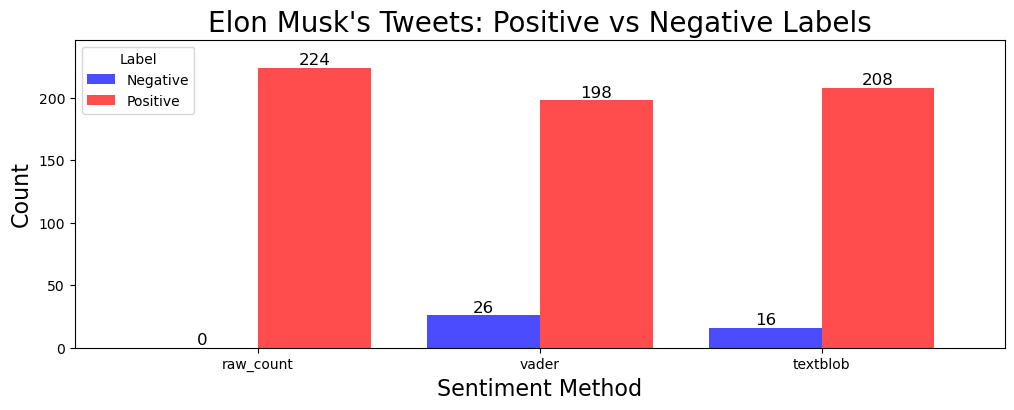

In [29]:

# Count the number of positive and negative labels for each sentiment method
label_counts = pd.DataFrame({
    'raw_count': tweets_market_open['raw_count_label'].value_counts(sort=False),
    'vader': tweets_market_open['vader_label'].value_counts(sort=False),
    'textblob': tweets_market_open['textblob_label'].value_counts(sort=False)
}).transpose()

# Rename columns for clarity
label_counts.columns = ['Negative', 'Positive']

# Plot the counts with custom colors and adjusted figure size
ax = label_counts.plot(kind='bar', figsize=(12, 4), color=['blue', 'red'], alpha=0.7, width=0.8)
plt.title('Elon Musk\'s Tweets: Positive vs Negative Labels', fontsize=20)
plt.xlabel('Sentiment Method', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='Label', loc='upper left')

# Adjust the y-axis limits
ax.set_ylim(0, label_counts.max().max() * 1.1)

# Adding labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Tesla/figure_0.3.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Performance Evaluation

In [30]:
# Drop rows where quote = 1
tweets_market_open = tweets_market_open[tweets_market_open['quote'] != 1]

In [31]:
from sklearn.metrics import classification_report

# Merge the true labels from the price window dataset
price_window_df['label'] = price_window_df.apply(lambda row: 1 if row['T10'] >= row['T0'] else 0, axis=1)
tweets_market_open = tweets_market_open.merge(price_window_df[['label']], left_on='id', right_index=True, how='inner')

# Extract the true labels and predicted labels
true_labels = tweets_market_open['label']
raw_count_pred_labels = tweets_market_open['raw_count_label']
vader_pred_labels = tweets_market_open['vader_label']
textblob_pred_labels = tweets_market_open['textblob_label']

# Print detailed classification reports for each sentiment method
print("\nRaw Count Classification Report:")
print(classification_report(true_labels, raw_count_pred_labels))

print("\nVADER Classification Report:")
print(classification_report(true_labels, vader_pred_labels))

print("\nTextBlob Classification Report:")
print(classification_report(true_labels, textblob_pred_labels))


Raw Count Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.58      1.00      0.73        36

    accuracy                           0.58        62
   macro avg       0.29      0.50      0.37        62
weighted avg       0.34      0.58      0.43        62


VADER Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.04      0.06        26
           1       0.55      0.83      0.66        36

    accuracy                           0.50        62
   macro avg       0.34      0.44      0.36        62
weighted avg       0.38      0.50      0.41        62


TextBlob Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.04      0.07        26
           1       0.57      0.92      0.70        36

    accuracy                           0.55        62
   macro avg       0.41      0.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Sentiment Analysis on Elon Musk's Tweets (Supervised)

## Introduction

This notebook conducts a supervised sentiment analysis on Elon Musk's tweets, aiming to understand their impact on Tesla's stock performance. The analysis utilizes several machine learning models to classify the sentiment of tweets and predict market reactions. The key components of this analysis include:

1. **Naive Bayes Classification**: A probabilistic model that uses Bayes' theorem with strong independence assumptions to classify tweet sentiment.
2. **Support Vector Machine (SVM)**: A powerful classification algorithm that seeks to find the optimal hyperplane to separate different sentiment classes.
3. **Logistic Regression**: A statistical model that estimates the probability of a tweet belonging to a particular sentiment class based on its features.
4. **Word2Vec Embedding**: A method of converting words into vector representations, capturing semantic relationships between words, which is then used in classification models.
5. **BERT (Bidirectional Encoder Representations from Transformers)**: A state-of-the-art transformer-based model designed by Google, which excels at understanding the context of words in relation to one another. BERT is used here for sequence classification to predict the sentiment of tweets with high accuracy.

The objective of this analysis is to compare the performance of these supervised learning methods in predicting the sentiment of Elon Musk's tweets and how effectively they correlate with subsequent movements in Tesla's stock price. By leveraging these machine learning techniques, this study aims to contribute to the understanding of how social media sentiment can influence financial markets.

In [32]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import math
import gensim
from gensim.models import Word2Vec 
from sklearn.decomposition import PCA
from adjustText import adjust_text

## 1. Naive Bayes Classification

In [33]:
# Prepare the data
reviews = tweets_market_open['content_stems'].values
encoded_labels = tweets_market_open['label'].values
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    reviews, encoded_labels, stratify=encoded_labels, random_state=42)

# Vectorization
vec = CountVectorizer(max_features=3000)
X = vec.fit_transform(train_sentences).toarray()
vocab = vec.get_feature_names_out()

# Count word occurrences per label
word_counts = {l: defaultdict(lambda: 0) for l in range(2)}
for i in range(X.shape[0]):
    l = train_labels[i]
    for j in range(len(vocab)):
        word_counts[l][vocab[j]] += X[i][j]

# Define Laplace smoothing function
def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label):
    a = word_counts[text_label][word] + 1
    b = n_label_items[text_label] + len(vocab)
    return math.log(a / b)

# Group data by label
def group_by_label(x, y, labels):
    return {l: x[np.where(y == l)] for l in labels}

# Fit the model
def fit(x, y, labels):
    n_label_items = {}
    log_label_priors = {}
    n = len(x)
    grouped_data = group_by_label(x, y, labels)
    for l, data in grouped_data.items():
        n_label_items[l] = len(data)
        log_label_priors[l] = math.log(n_label_items[l] / n)
    return n_label_items, log_label_priors

# Predict using the model
def predict(n_label_items, vocab, word_counts, log_label_priors, labels, x):
    result = []
    for text in x:
        label_scores = {l: log_label_priors[l] for l in labels}
        words = set(text.split())
        for word in words:
            if word not in vocab:
                continue
            for l in labels:
                log_w_given_l = laplace_smoothing(n_label_items, vocab, word_counts, word, l)
                label_scores[l] += log_w_given_l
        result.append(max(label_scores, key=label_scores.get))
    return result

# Train and predict
labels = [0, 1]
n_label_items, log_label_priors = fit(train_sentences, train_labels, labels)
pred = predict(n_label_items, vocab, word_counts, log_label_priors, labels, test_sentences)

# Evaluation
print("\nNaive Bayes Metrics:")
print("Accuracy:", accuracy_score(test_labels, pred))
print(classification_report(test_labels, pred))


Naive Bayes Metrics:
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.53      0.89      0.67         9

    accuracy                           0.50        16
   macro avg       0.27      0.44      0.33        16
weighted avg       0.30      0.50      0.38        16



## 2. Support Vector Machine (SVM)

In [35]:
# Prepare the data
text = tweets_market_open['content_stems'].values
labels = tweets_market_open['label'].values
text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.25, random_state=42)

# Vectorization
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(text_train)
features_test = vectorizer.transform(text_test)

# Train the SVM model
svm = SVC(kernel='linear')
svm.fit(features_train, labels_train)

# Predictions
predictions = svm.predict(features_test)

# Evaluation
print("\nSVM Metrics:")
print("Accuracy:", accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions))


SVM Metrics:
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      0.45      0.62        11

    accuracy                           0.62        16
   macro avg       0.73      0.73      0.62        16
weighted avg       0.83      0.62      0.62        16



## 3. Logistic Regression

In [36]:
# Prepare the data
x = tweets_market_open['content_stems'].values
y = tweets_market_open['label'].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, stratify=y)

# Vectorization
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# Grid search for hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), 
                    param_grid, cv=StratifiedKFold(n_splits=5))
grid.fit(x_train_vec, y_train)

# Best parameters and model fitting
print("Best parameter C:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
best_model = grid.best_estimator_
best_model.fit(x_train_vec, y_train)

# Predictions and evaluation
y_pred = best_model.predict(x_test_vec)
print("\nLogistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter C: {'C': 1}
Best cross-validation score: 0.5866666666666667

Logistic Regression Metrics:
Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.56      1.00      0.72         9

    accuracy                           0.56        16
   macro avg       0.28      0.50      0.36        16
weighted avg       0.32      0.56      0.40        16



/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

## 4. Word2Vec Embedding

In [37]:
# Prepare the data
df_content = tweets_market_open['content_stems'].apply(lambda x: x.split()).reset_index(drop=True)

# Train Word2Vec model
gensim_model = Word2Vec(sentences=df_content, vector_size=100, window=5, sg=1, 
                        negative=10, alpha=0.025, min_alpha=0.0001, epochs=5, 
                        min_count=1, workers=1, seed=92)

# Function to convert words to vectors
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += gensim_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

# Generate Word2Vec feature vectors
wordvec_arrays = np.zeros((len(df_content), 100)) 
for i in range(len(df_content)):
    wordvec_arrays[i, :] = word_vector(df_content[i], 100)
wordvec_df = pd.DataFrame(wordvec_arrays)

# Split data and train Logistic Regression on Word2Vec features
X = wordvec_df
y = tweets_market_open['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\nWord2Vec Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Word2Vec Metrics:
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.69      1.00      0.81        11

    accuracy                           0.69        16
   macro avg       0.34      0.50      0.41        16
weighted avg       0.47      0.69      0.56        16



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. BERT (Bidirectional Encoder Representations from Transformers)

In [38]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import nltk
import random

nltk.download('punkt')
pattern = r"(?u)\b\w+\b"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[nltk_data] Downloading package punkt to /Users/sunlexlin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# Function to preprocess the text
def preprocess_text(texts):
    # Convert to lowercase, fix contractions, and strip whitespace
    texts = [contractions.fix(text.lower().strip()) for text in texts]
    # Tokenize texts
    tokens = [nltk.regexp_tokenize(text, pattern) for text in texts]
    # Normalize unicode characters and remove non-ascii characters
    tokens = [[unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in token_list] for token_list in tokens]
    return tokens

# Apply preprocessing
tokens_bert = preprocess_text(tweets_market_open['content'])
tweets_market_open['content_tokens_bert'] = [' '.join(doc) for doc in tokens_bert]

In [40]:
# Create a custom dataset class for BERT
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Function to create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        texts=df.content_tokens_bert.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

In [41]:
# Function to fine-tune the model and evaluate
def fine_tune_and_evaluate(df_train, df_test, max_len, batch_size, epochs=3):
    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Data Loaders
    train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
    test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

    # Model Setup
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds)
            true_labels.extend(labels)

    # Convert predictions and labels to CPU tensors
    predictions = torch.stack(predictions).cpu()
    true_labels = torch.stack(true_labels).cpu()

    # Print evaluation metrics
    print(f"\nMax Length: {max_len}, Batch Size: {batch_size}")
    print("Accuracy:", accuracy_score(true_labels, predictions))
    print(classification_report(true_labels, predictions, zero_division=0))


In [42]:
# Experiment with different max_length and batch_size combinations
max_lengths = [64, 128, 256]
batch_sizes = [8, 16, 32]

df_train, df_test = train_test_split(tweets_market_open, test_size=0.25, random_state=SEED, stratify=tweets_market_open['label'])

for max_len in max_lengths:
    for batch_size in batch_sizes:
        fine_tune_and_evaluate(df_train, df_test, max_len, batch_size)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 6/6 [00:13<00:00,  2.31s/it]



Max Length: 64, Batch Size: 8
Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.56      1.00      0.72         9

    accuracy                           0.56        16
   macro avg       0.28      0.50      0.36        16
weighted avg       0.32      0.56      0.40        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 3/3 [00:09<00:00,  3.31s/it]



Max Length: 64, Batch Size: 16
Accuracy: 0.625
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.60      1.00      0.75         9

    accuracy                           0.62        16
   macro avg       0.80      0.57      0.50        16
weighted avg       0.77      0.62      0.53        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 2/2 [00:06<00:00,  3.09s/it]



Max Length: 64, Batch Size: 32
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.64      1.00      0.78         9

    accuracy                           0.69        16
   macro avg       0.82      0.64      0.61        16
weighted avg       0.80      0.69      0.63        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]



Max Length: 128, Batch Size: 8
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.64      1.00      0.78         9

    accuracy                           0.69        16
   macro avg       0.82      0.64      0.61        16
weighted avg       0.80      0.69      0.63        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 3/3 [00:15<00:00,  5.16s/it]



Max Length: 128, Batch Size: 16
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.64      1.00      0.78         9

    accuracy                           0.69        16
   macro avg       0.82      0.64      0.61        16
weighted avg       0.80      0.69      0.63        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 2/2 [00:15<00:00,  7.71s/it]



Max Length: 128, Batch Size: 32
Accuracy: 0.625
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.60      1.00      0.75         9

    accuracy                           0.62        16
   macro avg       0.80      0.57      0.50        16
weighted avg       0.77      0.62      0.53        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 6/6 [00:28<00:00,  4.71s/it]



Max Length: 256, Batch Size: 8
Accuracy: 0.625
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.60      1.00      0.75         9

    accuracy                           0.62        16
   macro avg       0.80      0.57      0.50        16
weighted avg       0.77      0.62      0.53        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 3/3 [00:33<00:00, 11.04s/it]



Max Length: 256, Batch Size: 16
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.62      0.89      0.73         9

    accuracy                           0.62        16
   macro avg       0.64      0.59      0.56        16
weighted avg       0.64      0.62      0.58        16



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████████████████████████████| 2/2 [00:37<00:00, 18.78s/it]



Max Length: 256, Batch Size: 32
Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.56      1.00      0.72         9

    accuracy                           0.56        16
   macro avg       0.28      0.50      0.36        16
weighted avg       0.32      0.56      0.40        16

